In [3]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers, applications

In [2]:
# Define dataset path
dataset_dir = "C:/Users/samik/Documents/GitHub/MS-disease/SplitDataset"

In [3]:
# Define batch size and image size
img_size = (146, 81)
batch_size = 128  

In [4]:
# Function to convert grayscale to RGB (ResNet expects 3-channel input)
def preprocess_image(image, label):
    image = tf.image.grayscale_to_rgb(image)  # Convert 1-channel grayscale to 3-channel RGB
    return image, label

# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_dir, "train"),
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale",
    label_mode="binary"
).map(preprocess_image)  # Convert grayscale to RGB

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_dir, "val"),
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale",
    label_mode="binary"
).map(preprocess_image)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale",
    label_mode="binary"
).map(preprocess_image)

# Optimize dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 198798 files belonging to 2 classes.
Found 24849 files belonging to 2 classes.
Found 24851 files belonging to 2 classes.


In [5]:
# Load the ResNet50 model (excluding top layers)
base_model = applications.ResNet50(
    weights="imagenet",  # Use pretrained weights
    input_shape=(146, 81, 3),  # ResNet expects 3-channel RGB images
    include_top=False  # Remove original classification layers
)

# Freeze the base model layers (optional: Fine-tune later)
base_model.trainable = False  

# Build the ResNet-based model
model = keras.Sequential([
    base_model,  # Pretrained ResNet50 as feature extractor
    layers.GlobalAveragePooling2D(),  # Reduces dimensions
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),  # Dropout for regularization
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),  # Lower LR for transfer learning
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ ?                           │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [6]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    batch_size=batch_size
)

# Evaluate on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

model.save("ms_detection_Resnet50.h5")

Epoch 1/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 3184s 2s/step - accuracy: 0.8467 - loss: 0.3280 - val_accuracy: 0.8885 - val_loss: 0.2440
Epoch 2/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 3087s 2s/step - accuracy: 0.8828 - loss: 0.2508 - val_accuracy: 0.8932 - val_loss: 0.2324
Epoch 3/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 9711s 6s/step - accuracy: 0.8896 - loss: 0.2377 - val_accuracy: 0.8960 - val_loss: 0.2258
Epoch 4/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 4062s 3s/step - accuracy: 0.8955 - loss: 0.2285 - val_accuracy: 0.8979 - val_loss: 0.2211
Epoch 5/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 2951s 2s/step - accuracy: 0.8986 - loss: 0.2217 - val_accuracy: 0.9007 - val_loss: 0.2176
Epoch 6/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 2900s 2s/step - accuracy: 0.9015 - loss: 0.2164 - val_accuracy: 0.9013 - val_loss: 0.2146
Epoch 7/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 2891s 2s/step - accuracy: 0.9031 - loss: 0.2120 - val_accuracy: 0.9029 - val_loss: 0.2125
Epoch 8/10
1554/1554 ━━━━━━━━━━━━━━━━━━━━ 2940s 2s/step - accuracy: 0.9071 -

Test Accuracy: 0.9095


In [1]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: C:\Users\samik\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# ✅ Load the trained model
model = tf.keras.models.load_model("ms_detection_Resnet50.h5")

In [5]:
# ✅ Load the test dataset
dataset_dir = "C:/Users/samik/Documents/GitHub/MS-disease/SplitDataset"
img_size = (146, 81)
batch_size = 128

In [9]:
def preprocess_image(image, label):
    image = tf.image.grayscale_to_rgb(image)  # Convert 1-channel grayscale to 3-channel RGB
    return image, label

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(dataset_dir, "test"),
    image_size=img_size,
    batch_size=batch_size,
    color_mode="grayscale",  # Original data is grayscale
    label_mode="binary"
).map(preprocess_image)  # Convert grayscale to RGB


Found 24851 files belonging to 2 classes.


In [10]:
# ✅ Get the true labels (y_test) and images (X_test)
y_test = np.concatenate([y.numpy() for _, y in test_ds])
X_test = np.concatenate([x.numpy() for x, _ in test_ds])

In [11]:
# ✅ Make predictions
y_pred_prob = model.predict(X_test)  # Get probability scores
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary labels

777/777 ━━━━━━━━━━━━━━━━━━━━ 744s 951ms/step


In [12]:
# ✅ Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

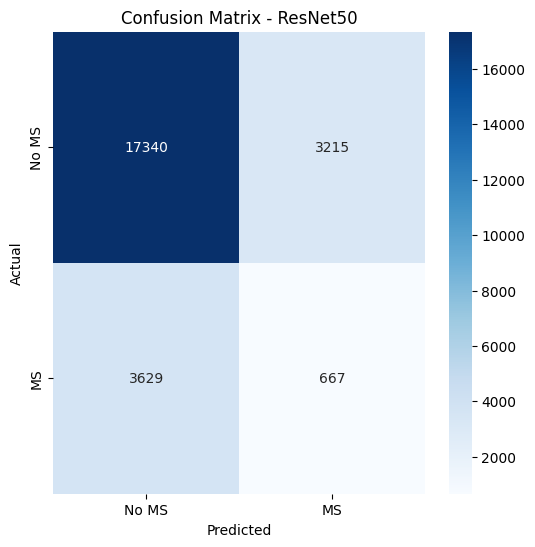

In [13]:
# ✅ Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No MS", "MS"], yticklabels=["No MS", "MS"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - ResNet50")
plt.show()

In [14]:

# ✅ Print classification report
print(classification_report(y_test, y_pred, target_names=["No MS", "MS"]))

              precision    recall  f1-score   support

       No MS       0.83      0.84      0.84     20555
          MS       0.17      0.16      0.16      4296

    accuracy                           0.72     24851
   macro avg       0.50      0.50      0.50     24851
weighted avg       0.71      0.72      0.72     24851

